In [1]:
%load_ext autoreload
%autoreload 2

### Visualize the variability of watermass transformation for the OM4 hindcast simulation

In [30]:
import xarray as xr
import so_decadal_variability.calc as socalc
import matplotlib.pyplot as plt
import numpy as np

In [61]:
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/work/gam/projects/so_decadal_variability/data/processed/'+config+'/G/'
form = 'surfacefluxes'
variables = ['heat','salt']
G = {}
G['total'] = xr.Dataset()
for variable in variables:
    G[variable] = xr.open_dataset(rootdir+form+'/G_'+variable+'.sigma0.nc')
    # HACK because of error in calculation that I still need to find
    if variable == 'salt': G[variable] = -1*G[variable]
    for i, process in enumerate(G[variable].data_vars):
        # Sum up variables (heat and salt)
        if process not in G['total'].data_vars: # If it's not there, create it
            G['total'][process] = xr.zeros_like(G[variable][process])
        # Then add to it
        G['total'][process] += G[variable][process]
        
        # Sum up processes
        if i==0:
            G[variable]['all']=xr.zeros_like(G[variable][process])
            G['total']['all']=xr.zeros_like(G[variable][process])
        G[variable]['all']+=G[variable][process]
        G['total']['all']+=G['total'][process]
        
variables.append('total')

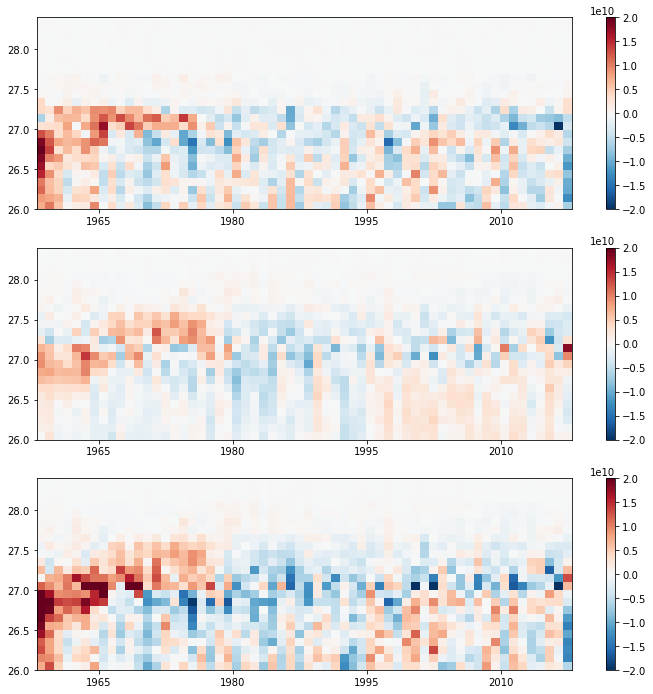

In [64]:
## Annual anomalies : TRANSFORMATION
n = len(variables)
process = 'all'
fig,ax = plt.subplots(figsize=(12,n*4),nrows=n)
for i, variable in enumerate(variables):
    x = socalc._annual(G[variable]['time'])
    y = G[variable]['sigma0_i']
    axnow = ax[i]
    im = axnow.pcolormesh(x,y,
                          socalc._annualanom(G[variable][process]).transpose(),
                          vmin=-2E10,vmax=2E10,cmap='RdBu_r',shading='auto')
    plt.colorbar(im,ax=axnow)

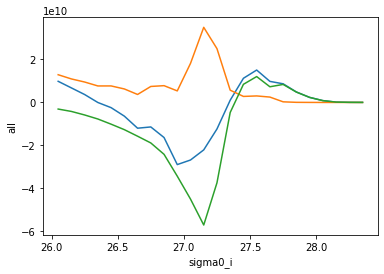

In [66]:
process = 'all'
G['total'][process].mean('time').plot(hue='time')
G['heat'][process].mean('time').plot(hue='time')
G['salt'][process].mean('time').plot(hue='time')

In [70]:
# Calculate transformation
dG = {}
upwelling = {}
for variable in variables:
    dG[variable] = xr.Dataset()
    upwelling[variable] = xr.Dataset()
    # Calculate formation for each component
    for process in G[variable].data_vars:
        dG[variable][process] = -1*G[variable][process].diff('sigma0_i')
        condition = socalc._annual(dG[variable][process])<0
        upwelling[variable][process] = socalc._annualanom(
            dG[variable][process]).where(condition,0).sel(sigma0_i=slice(26.5,9999)).sum('sigma0_i')

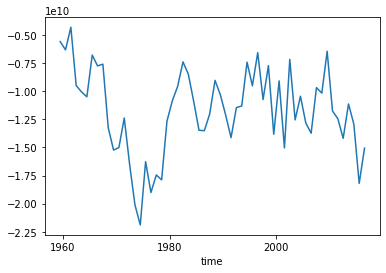

In [81]:
## Annual anomalies : UPWELLING
upwelling['total']['all'].rolling(time=3,center=True).mean().plot()